# Content based News Recommendation System

## Import Libraries

In [75]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import nltk
plt.rcParams['figure.figsize'] = (6,6)
import seaborn as sns
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Load Data

In [76]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
category             200853 non-null object
headline             200853 non-null object
authors              200853 non-null object
link                 200853 non-null object
short_description    200853 non-null object
date                 200853 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [78]:
df.shape

(200853, 6)

In [79]:
# Size by category
categories = df.groupby('category')
print("total categories:", categories.ngroups)
print(categories.size().head())

total categories: 41
category
ARTS              1509
ARTS & CULTURE    1339
BLACK VOICES      4528
BUSINESS          5937
COLLEGE           1144
dtype: int64


## Data Wrangling

In [80]:
# THE WORLDPOST and WORLDPOST should be the same category, so change 'THE WORLDPOST' to 'WORLDPOST'.
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [81]:
# Display number of articles, authors and categories
print("Total number of articles: ", df.shape[0])
print("Total number of authors: ", df["authors"].nunique())
print("Total number of unqiue categories: ", df["category"].nunique())

Total number of articles:  200853
Total number of authors:  27993
Total number of unqiue categories:  40


In [88]:
# Display Size by category
categories = df.groupby('category')
print("Total categories:", categories.ngroups)
print(categories.size().head())

Total categories: 40
category
ARTS              1509
ARTS & CULTURE    1339
BLACK VOICES      4528
BUSINESS          5937
COLLEGE           1144
dtype: int64


In [89]:
df.category.value_counts().head()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
Name: category, dtype: int64

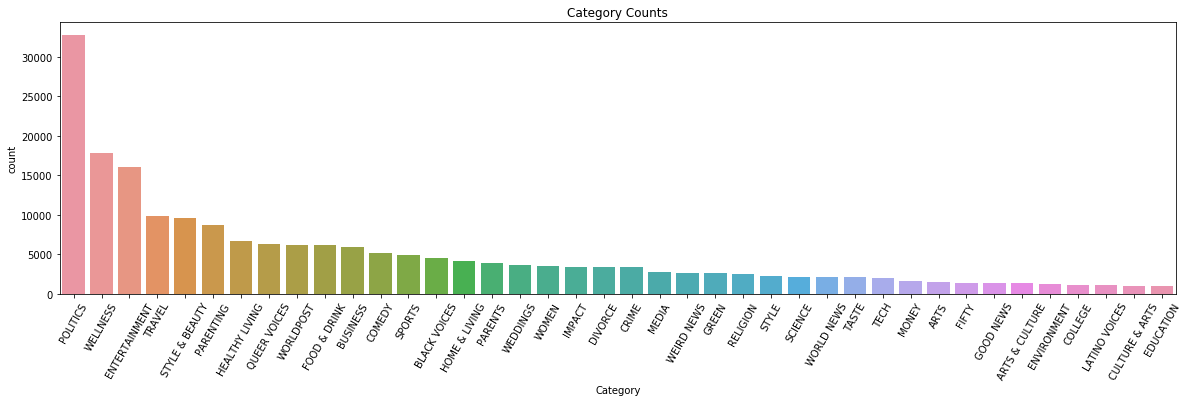

In [83]:
# Plot by category
figure, ax = plt.subplots(1, 1, figsize = (20, 5))

ax = sns.countplot(df['category'],order=df['category'].value_counts().index)
ax.set_title("Category Counts")
ax.set_xlabel("Category")
# Manipulate the labels to make them more readable
ax.set_xticklabels([x for x in ax.get_xticklabels()], rotation=60)
plt.show()

### From the above plot we observe that politics, wellness and entertainment are the top 3 news article categories.

### Let us consider only the latest articles from the year 2018 as the size of the dataset is quite large and processing may consume too much time.

In [90]:
# Filter for news articles from the year 2018
df = df[df['date'] >= pd.Timestamp(2018,1,1)]

In [91]:
# Display number of articles, authors and categories
print("Total number of articles : ", df.shape[0])
print("Total number of authors : ", df["authors"].nunique())
print("Total number of unqiue categories : ", df["category"].nunique())

Total number of articles :  8583
Total number of authors :  918
Total number of unqiue categories :  26


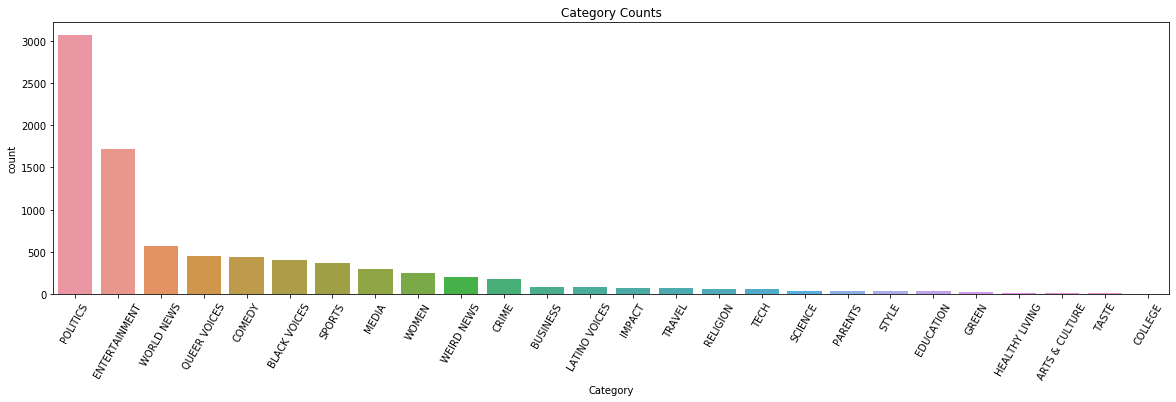

In [93]:
# Plot by category
figure, ax = plt.subplots(1, 1, figsize = (20, 5))

ax = sns.countplot(df['category'],order=df['category'].value_counts().index)
ax.set_title("Category Counts")
ax.set_xlabel("Category")
# Manipulate the labels to make them more readable
ax.set_xticklabels([x for x in ax.get_xticklabels()], rotation=60)
plt.show()

In [99]:
# Using headlines and short_description as input X
df['text'] = df.headline + " " + df.short_description

In [100]:
# Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

In [101]:
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [98]:
df.head()

,category,headline,authors,link,short_description,date,text,words,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[159, 93, 185, 468, 906, 5, 389, 101, 108, 35,...",27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[39, 686, 1172, 8079, 6, 8080, 5404, 7, 1, 163...",20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[3031, 3678, 5405, 7, 1, 56, 83, 14, 725, 5406...",25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[769, 1672, 1673, 11468, 514, 3033, 6, 152, 5,...",26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[11470, 11471, 819, 47, 10, 8081, 2580, 2, 907...",26


In [18]:
df.shape

(8583, 9)

In [53]:
df.word_length.describe()

count    8583.000000
mean       25.176861
std         6.418315
min         8.000000
25%        21.000000
50%        25.000000
75%        29.000000
max        53.000000
Name: word_length, dtype: float64

In [102]:
# check for any missing data
df.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
text                 0
words                0
word_length          0
dtype: int64

(0, 130)

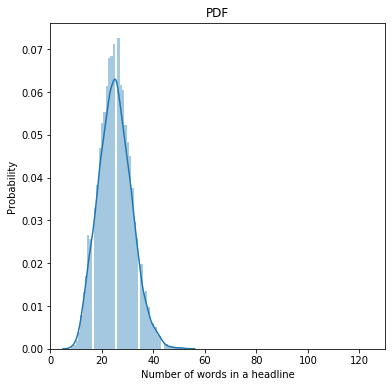

In [107]:
# PDF for the number of words in a headline
ax = sns.distplot(df.word_length)
ax.set_title('PDF')
ax.set_xlabel('Number of words in a headline')
ax.set_ylabel('Probability')
ax.set_xlim(0,130)

In [21]:
df.head()

,category,headline,authors,link,short_description,date,text,words,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,"[159, 93, 185, 468, 906, 5, 389, 101, 108, 35,...",27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,"[39, 686, 1172, 8079, 6, 8080, 5404, 7, 1, 163...",20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,"[3031, 3678, 5405, 7, 1, 56, 83, 14, 725, 5406...",25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"[769, 1672, 1673, 11468, 514, 3033, 6, 152, 5,...",26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,"[11470, 11471, 819, 47, 10, 8081, 2580, 2, 907...",26


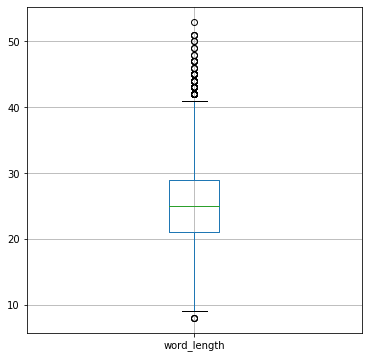

In [106]:
df.boxplot('word_length')

In [115]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df.text, df.category, test_size = 0.33)

In [116]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [117]:
train_set_len = len(X_train)
test_set_len = len(X_test)

## Text Preprocessing

### Stop words removal, tokenize and lemmatize

In [118]:
lemmatizer = WordNetLemmatizer()
def process_headlines(main_text):
    headlines_without_numbers = re.sub('[^a-zA-Z]', ' ', main_text)
    words = word_tokenize(headlines_without_numbers.lower())
    stop_words_english = set(stopwords.words('english'))
    final_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words_english]
    return(' '.join(final_words))

In [119]:
headlinesTrain = []
headlinesTest = []

In [120]:
for i in range(0, train_set_len):
    headlinesTrain.append(process_headlines(X_train[i]))

In [121]:
for i in range(0, test_set_len):
    headlinesTest.append(process_headlines(X_test[i]))

### Bag Of Words - Count Vectorizer

In [122]:
from sklearn.feature_extraction.text import CountVectorizer

vectorize = CountVectorizer(analyzer = "word", max_df=0.5,min_df=2, ngram_range=(1, 2), max_features=10000)

bagOfWords_train = vectorize.fit_transform(headlinesTrain)
X_train = bagOfWords_train.toarray()

bagOfWords_test = vectorize.transform(headlinesTest)
X_test = bagOfWords_test.toarray()

## Preliminary model evaluation using default parameters

In [123]:
#Preliminary model evaluation using default parameters
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#Creating a dict of the models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'Logistic Regression': LogisticRegression(n_jobs = -1),
              'LinearSVM': LinearSVC(),
              'K Nearest Neighbor': KNeighborsClassifier()}


#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

results_df = model_score_df(model_dict)


/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/priyasathish/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

In [70]:
results_df

,model_name,accuracy_score,precision_score,recall_score,f1_score
7,LinearSVM,0.666078,0.452625,0.328205,0.36622
1,Stochastic Gradient Descent,0.682316,0.59672,0.305721,0.358697
6,Logistic Regression,0.689375,0.581914,0.301341,0.356729
3,Decsision Tree,0.584539,0.345634,0.257183,0.28229
2,Random Forest,0.633251,0.379824,0.225787,0.259581
5,Gaussian Naive Bayes,0.545358,0.395019,0.141648,0.164515
8,K Nearest Neighbor,0.417226,0.311188,0.133848,0.144641
0,Dummy,0.190964,0.0400646,0.0404579,0.040161
4,AdaBoost,0.352277,0.0366959,0.0425251,0.0270737


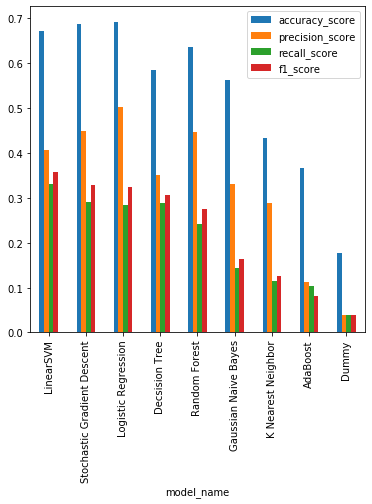

In [124]:
results_df.plot(kind='bar',x='model_name')